In [1]:
! echo "--- Visible GPUs ---"; rocm-smi --showid;  echo ""; echo "--- Visible CPUs ---"; echo "CPUs available to this process: $(nproc)"; echo ""; echo "--- Visible Memory (RAM) ---"; free -h;

--- Visible GPUs ---
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)
/bin/bash: line 1: $'\302\240': command not found
--- Visible CPUs ---
CPUs available to this process: 256

--- Visible Memory (RAM) ---
               total        used        free      shared  buff/cache   available
Mem:           1.0Ti       9.2Gi       999Gi       431Mi       1.9Gi       997Gi
Swap:             0B          0B          0B


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import sklearn as skl
from tensorflow import keras
from tensorflow.keras import layers

# Load SNP data from CSV file (already transposed, GIDs as row names, SNPs as columns)
def load_snp_csv(snp_file):
        df = pd.read_csv(snp_file, index_col=0)  # GIDs are row indices
        df = df.astype(float)  # Ensure numerical values
        return df

# Load height data from CSV file
def load_yield_data(yield_file):
        yield_df = pd.read_csv(yield_file)
        return yield_df.set_index("GID_filtered")  # Ensure genetic ID is the index
    
print("done 1")

done 1


In [3]:
# Load the data

X = load_snp_csv("SNPs_phased_reduced.csv")

print("done 2")

done 2


In [4]:
Y = load_yield_data("yield_data_reduced1.csv")
print("done 2.5")

done 2.5


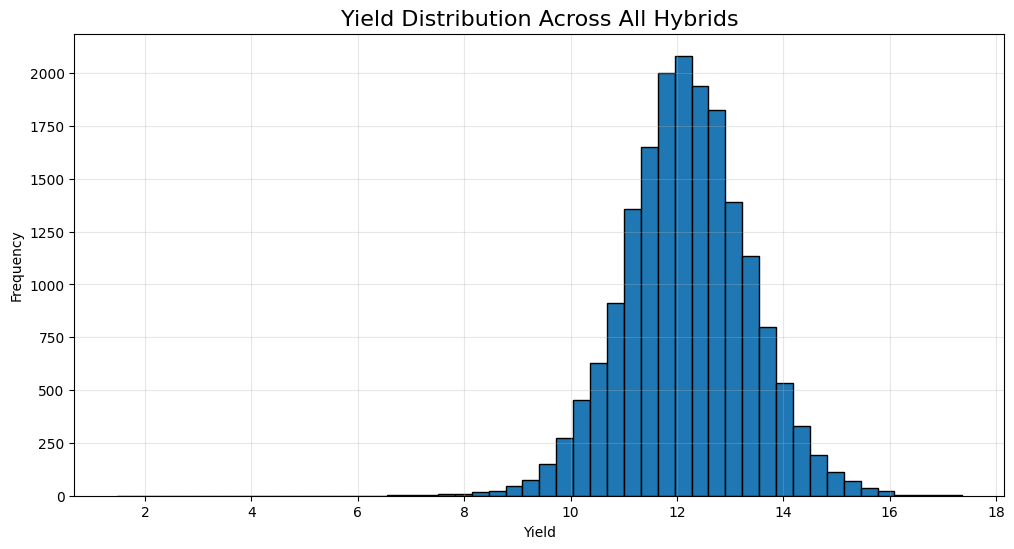

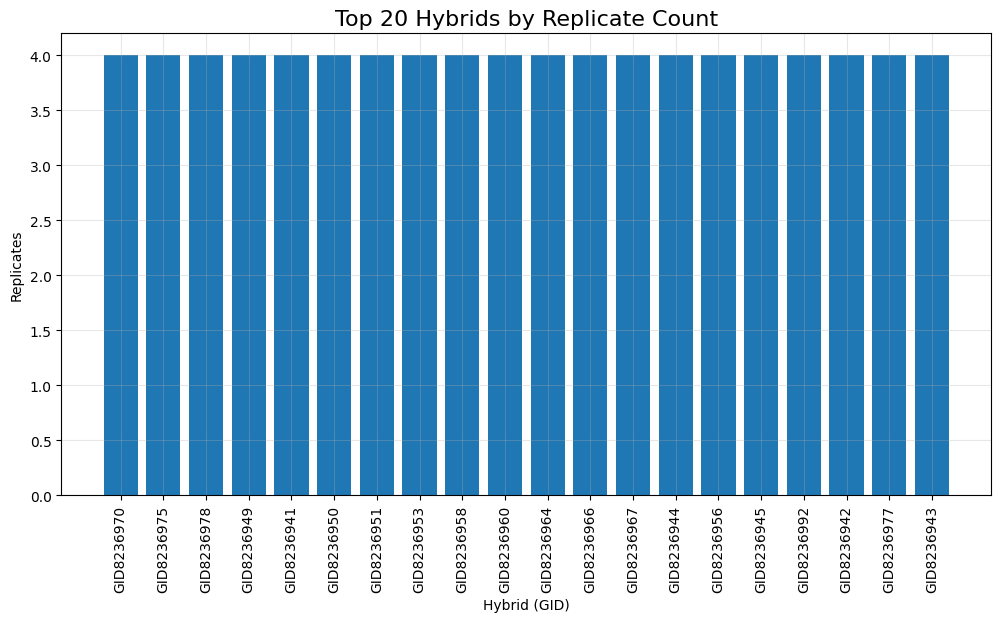

/tmp/ipykernel_1104618/986402976.py:35: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=top_gids, patch_artist=True)


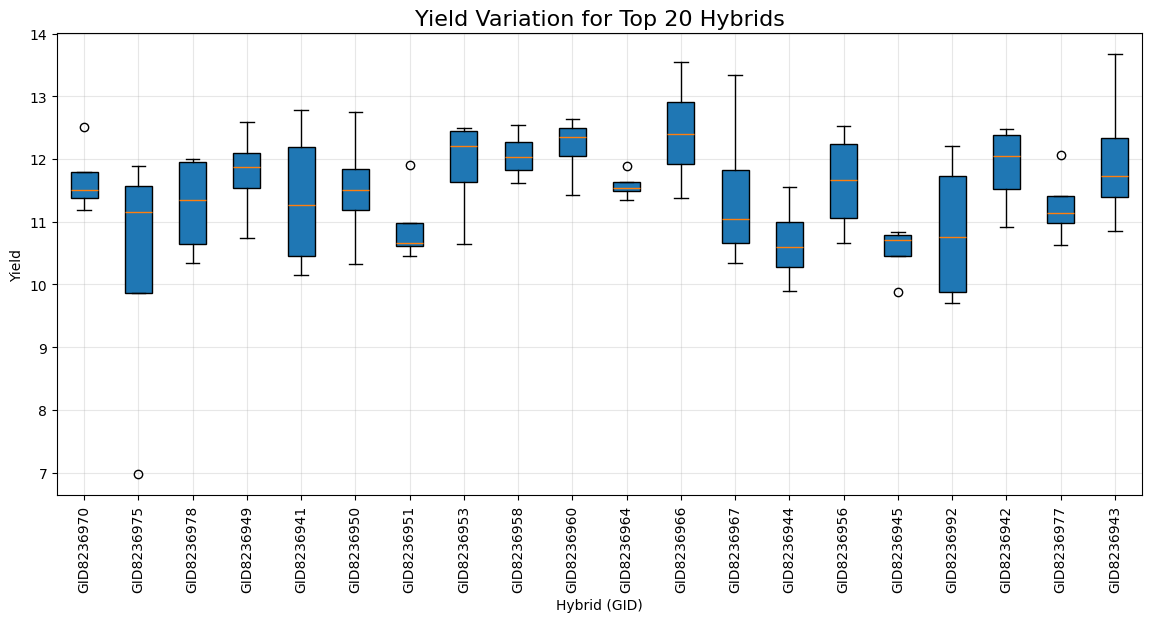

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your data (adjust path if needed)
Y = pd.read_csv("yield_data_reduced1.csv")  # columns: ['GID', 'yield']

# --- 1️⃣ Overall yield distribution ---
plt.figure(figsize=(12, 6))
plt.hist(Y['Y'], bins=50, edgecolor='black')
plt.title("Yield Distribution Across All Hybrids", fontsize=16)
plt.xlabel("Yield")
plt.ylabel("Frequency")
plt.grid(True, alpha=0.3)
plt.show()

# --- 2️⃣ Replicate counts per GID ---
rep_counts = Y['GID_filtered'].value_counts().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
plt.bar(rep_counts.index[:20], rep_counts.values[:20])
plt.title("Top 20 Hybrids by Replicate Count", fontsize=16)
plt.xlabel("Hybrid (GID)")
plt.ylabel("Replicates")
plt.xticks(rotation=90)
plt.grid(True, alpha=0.3)
plt.show()

# --- 3️⃣ Boxplot of yield variation per line (top 20 most replicated) ---
top_gids = rep_counts.index[:20]
data_top = Y[Y['GID_filtered'].isin(top_gids)]

# Manual boxplot (no seaborn)
plt.figure(figsize=(14, 6))
data_to_plot = [data_top[data_top['GID_filtered'] == gid]['Y'].values for gid in top_gids]
plt.boxplot(data_to_plot, labels=top_gids, patch_artist=True)
plt.title("Yield Variation for Top 20 Hybrids", fontsize=16)
plt.xlabel("Hybrid (GID)")
plt.ylabel("Yield")
plt.xticks(rotation=90)
plt.grid(True, alpha=0.3)
plt.show()

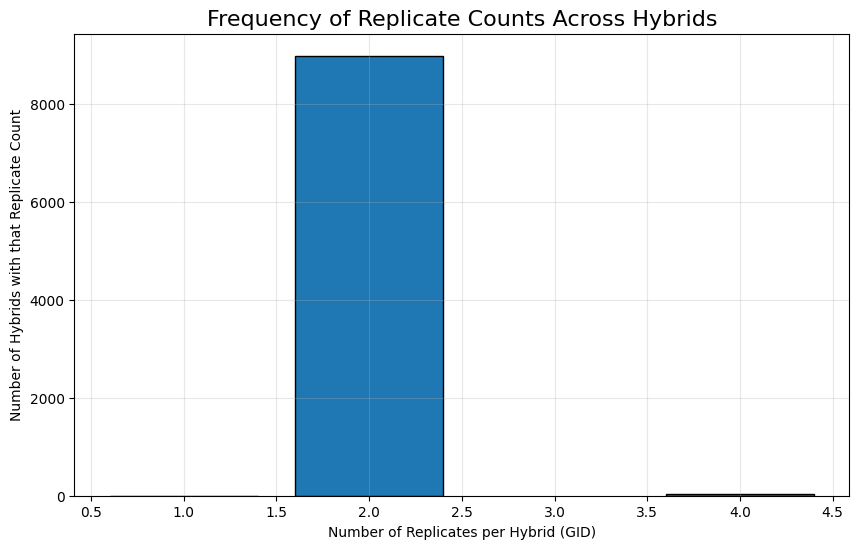

count
1       1
2    8986
4      28
Name: count, dtype: int64


In [14]:
# --- Count how many replicates per GID ---
rep_counts = Y['GID_filtered'].value_counts()

# --- Count how many GIDs fall into each replicate count ---
rep_freq = rep_counts.value_counts().sort_index()

# --- Plot the frequency of replicate counts ---
plt.figure(figsize=(10, 6))
plt.bar(rep_freq.index, rep_freq.values, width=0.8, edgecolor='black')
plt.title("Frequency of Replicate Counts Across Hybrids", fontsize=16)
plt.xlabel("Number of Replicates per Hybrid (GID)")
plt.ylabel("Number of Hybrids with that Replicate Count")
plt.grid(True, alpha=0.3)
plt.show()

print(rep_freq.head(10))

In [5]:
# Ensure that we only use samples that have height data
matching_samples = list(set(X.index) & set(Y.index))

# Filter SNP and height data for matching samples
X = X.loc[matching_samples]  # GIDs are already rows
Y = Y.loc[matching_samples, "Y"].values.flatten()

print("done 3")

done 3


In [6]:
len(Y)

18085

In [7]:
# Split and normalise data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("done 4")


done 4


In [8]:
print(X_train_scaled.shape)

(14468, 84322)


In [10]:

# Build the neural network model
#model = keras.Sequential([
#    layers.Input(shape=(X_train.shape[1],)),
#    layers.Dense(128, activation='relu'),
#    layers.Dropout(0.3),
#    layers.Dense(64, activation='relu'),
#    layers.Dense(1)
#])

model = keras.Sequential([
    layers.Input(shape=(X_train_scaled.shape[1],)),
    layers.Dense(256, activation='relu'),  
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae', tf.keras.metrics.RootMeanSquaredError()])

# Train the model
history = model.fit(X_train_scaled, Y_train, epochs=100, batch_size=32, validation_split=0.2)


Epoch 1/100
362/362 [==============================] - 28s 68ms/step - loss: 16.4910 - mae: 2.6828 - root_mean_squared_error: 4.0609 - val_loss: 1.5058 - val_mae: 0.9293 - val_root_mean_squared_error: 1.2271
Epoch 2/100
362/362 [==============================] - 23s 63ms/step - loss: 2.6536 - mae: 1.2907 - root_mean_squared_error: 1.6290 - val_loss: 1.3143 - val_mae: 0.8834 - val_root_mean_squared_error: 1.1464
Epoch 3/100
362/362 [==============================] - 22s 62ms/step - loss: 2.1456 - mae: 1.1590 - root_mean_squared_error: 1.4648 - val_loss: 1.1507 - val_mae: 0.8201 - val_root_mean_squared_error: 1.0727
Epoch 4/100
362/362 [==============================] - 23s 62ms/step - loss: 1.9971 - mae: 1.1215 - root_mean_squared_error: 1.4132 - val_loss: 1.0595 - val_mae: 0.7875 - val_root_mean_squared_error: 1.0293
Epoch 5/100
362/362 [==============================] - 23s 62ms/step - loss: 1.8493 - mae: 1.0766 - root_mean_squared_error: 1.3599 - val_loss: 1.1628 - val_mae: 0.8244 - 

In [9]:
from tensorflow.keras.models import load_model
model = load_model("wheat_height_predictor.h5")

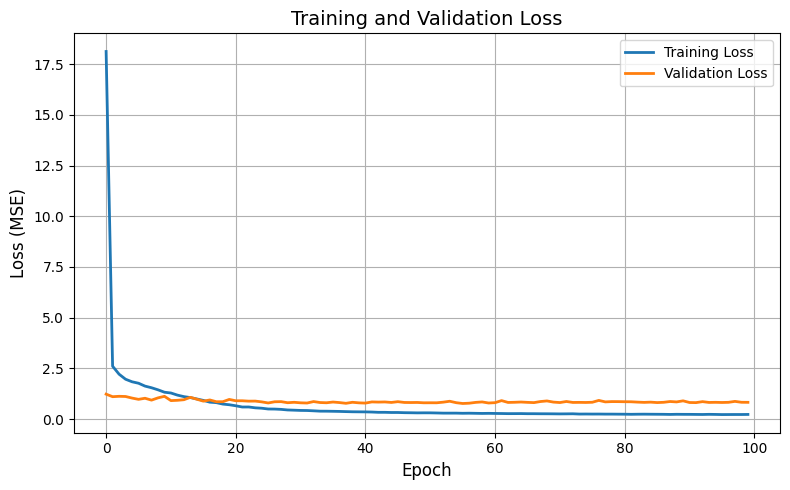

In [8]:
import matplotlib.pyplot as plt

# Assuming 'history' is the result from model.fit()
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.title('Training and Validation Loss', fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Generating predictions...
114/114 [==============================] - 1s 8ms/step

Training Metrics (with 95% CI):
  R²: 0.7097  (95% CI: 0.6968 – 0.7235)
  RMSE: 0.6313  (95% CI: 0.6147 – 0.6498)
  RMSPE (%): 7.4885  (95% CI: 5.2913 – 11.2590)

Validation Metrics (with 95% CI):
  R²: 0.6823  (95% CI: 0.6513 – 0.7108)
  RMSE: 0.6424  (95% CI: 0.6118 – 0.6775)
  RMSPE (%): 5.6382  (95% CI: 5.2528 – 6.0698)


/tmp/ipykernel_326976/1776810164.py:61: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([train_errors, val_errors],


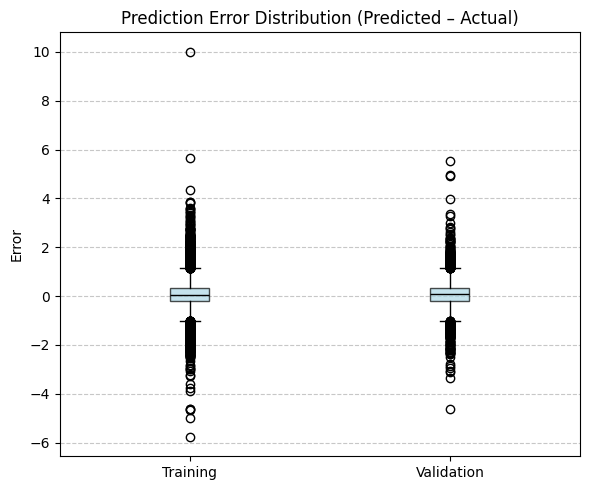

/tmp/ipykernel_326976/1776810164.py:83: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(residuals_by_bin,


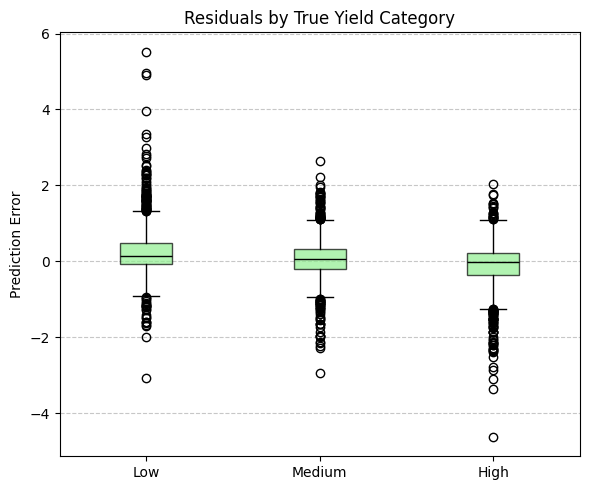

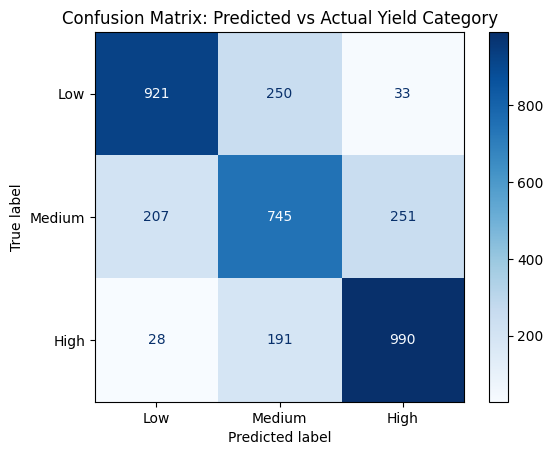

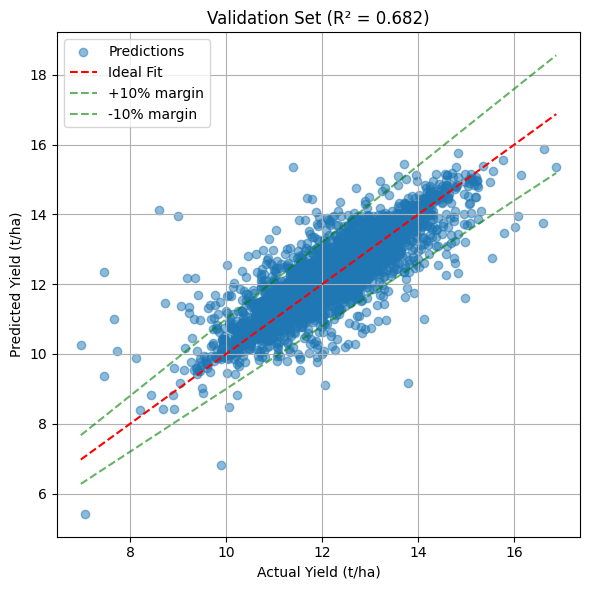

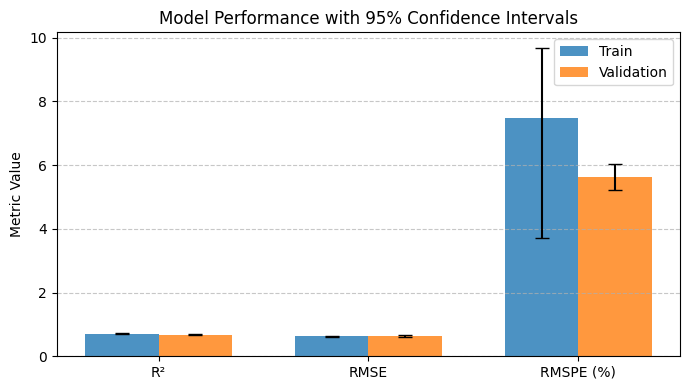

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error, confusion_matrix, ConfusionMatrixDisplay

# --- 1. Metric functions ---
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def rmspe(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    return np.sqrt(np.mean(((y_true[mask] - y_pred[mask]) / y_true[mask]) ** 2)) * 100

# --- 2. Bootstrapping confidence intervals ---
def bootstrap_ci(metric_func, y_true, y_pred, n_bootstrap=1000, ci=95):
    rng = np.random.default_rng(42)
    scores = []
    n = len(y_true)
    for _ in range(n_bootstrap):
        idx = rng.choice(np.arange(n), n, replace=True)
        scores.append(metric_func(y_true[idx], y_pred[idx]))
    lower = np.percentile(scores, (100 - ci) / 2)
    upper = np.percentile(scores, 100 - (100 - ci) / 2)
    return np.mean(scores), lower, upper

# --- 3. Generate predictions ---
print("Generating predictions...")
y_pred_train = model.predict(X_train_scaled).flatten()
y_pred_val = model.predict(X_test_scaled).flatten()

y_true_train = Y_train
y_true_val = Y_test

# --- 4. Compute metrics with bootstrap CIs for both sets ---
metrics_train = {
    'R²': bootstrap_ci(lambda yt, yp: r2_score(yt, yp), y_true_train, y_pred_train),
    'RMSE': bootstrap_ci(lambda yt, yp: rmse(yt, yp), y_true_train, y_pred_train),
    'RMSPE (%)': bootstrap_ci(lambda yt, yp: rmspe(yt, yp), y_true_train, y_pred_train),
}

metrics_val = {
    'R²': bootstrap_ci(lambda yt, yp: r2_score(yt, yp), y_true_val, y_pred_val),
    'RMSE': bootstrap_ci(lambda yt, yp: rmse(yt, yp), y_true_val, y_pred_val),
    'RMSPE (%)': bootstrap_ci(lambda yt, yp: rmspe(yt, yp), y_true_val, y_pred_val),
}

# --- 5. Print results ---
def print_metrics(label, metrics):
    print(f"\n{label} Metrics (with 95% CI):")
    for k, (mean, low, high) in metrics.items():
        print(f"  {k}: {mean:.4f}  (95% CI: {low:.4f} – {high:.4f})")

print_metrics("Training", metrics_train)
print_metrics("Validation", metrics_val)

# --- 6. Error distributions ---
train_errors = y_pred_train - y_true_train
val_errors = y_pred_val - y_true_val

plt.figure(figsize=(6, 5))
plt.boxplot([train_errors, val_errors],
            labels=["Training", "Validation"],
            patch_artist=True,
            medianprops=dict(color='black'),
            boxprops=dict(facecolor='lightblue', alpha=0.7))
plt.title("Prediction Error Distribution (Predicted – Actual)")
plt.ylabel("Error")
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# --- 7. Yield binning for residual analysis ---
percentiles = np.percentile(y_true_val, [33.3, 66.6])
bins = [y_true_val.min() - 1, percentiles[0], percentiles[1], y_true_val.max() + 1]
labels = ["Low", "Medium", "High"]

y_true_bins = np.digitize(y_true_val, bins) - 1
y_pred_bins = np.digitize(y_pred_val, bins) - 1

# --- 8. Boxplot of residuals by yield bin ---
residuals_by_bin = [val_errors[y_true_bins == i] for i in range(3)]
plt.figure(figsize=(6,5))
plt.boxplot(residuals_by_bin,
            labels=labels,
            patch_artist=True,
            medianprops=dict(color='black'),
            boxprops=dict(facecolor='lightgreen', alpha=0.7))
plt.title("Residuals by True Yield Category")
plt.ylabel("Prediction Error")
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# --- 9. Confusion matrix (predicted vs true yield bins) ---
cm = confusion_matrix(y_true_bins, y_pred_bins, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix: Predicted vs Actual Yield Category")
plt.show()

# --- 10. Predicted vs Actual scatter with ±10% band ---
def plot_pred_vs_actual_with_band(y_true, y_pred, title, band=0.1):
    plt.figure(figsize=(6,6))
    plt.scatter(y_true, y_pred, alpha=0.5, label="Predictions")
    min_val, max_val = np.min(y_true), np.max(y_true)
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label="Ideal Fit")

    # ±band lines (e.g., ±10%)
    plt.plot([min_val, max_val], [min_val*(1+band), max_val*(1+band)], 'g--', alpha=0.6, label=f"+{int(band*100)}% margin")
    plt.plot([min_val, max_val], [min_val*(1-band), max_val*(1-band)], 'g--', alpha=0.6, label=f"-{int(band*100)}% margin")

    plt.xlabel("Actual Yield (t/ha)")
    plt.ylabel("Predicted Yield (t/ha)")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_pred_vs_actual_with_band(
    y_true_val, y_pred_val,
    f"Validation Set (R² = {metrics_val['R²'][0]:.3f})"
)

# --- 11. Summary bar chart with CIs ---
labels_metrics = list(metrics_val.keys())
train_means = [metrics_train[m][0] for m in labels_metrics]
train_err_low = [metrics_train[m][0] - metrics_train[m][1] for m in labels_metrics]
train_err_high = [metrics_train[m][2] - metrics_train[m][0] for m in labels_metrics]
train_err = [train_err_high, train_err_low]

val_means = [metrics_val[m][0] for m in labels_metrics]
val_err_low = [metrics_val[m][0] - metrics_val[m][1] for m in labels_metrics]
val_err_high = [metrics_val[m][2] - metrics_val[m][0] for m in labels_metrics]
val_err = [val_err_high, val_err_low]

x = np.arange(len(labels_metrics))
width = 0.35

plt.figure(figsize=(7,4))
plt.bar(x - width/2, train_means, width, yerr=train_err, capsize=5, label="Train", alpha=0.8)
plt.bar(x + width/2, val_means, width, yerr=val_err, capsize=5, label="Validation", alpha=0.8)
plt.xticks(x, labels_metrics)
plt.ylabel("Metric Value")
plt.title("Model Performance with 95% Confidence Intervals")
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Yield Bin Summary (Validation Set):
Category   Range (t/ha)         Proportion (%) 
Low        5.78 – 11.69         33.3%
Medium     11.69 – 12.68         33.3%
High       12.68 – 18.36         33.4%


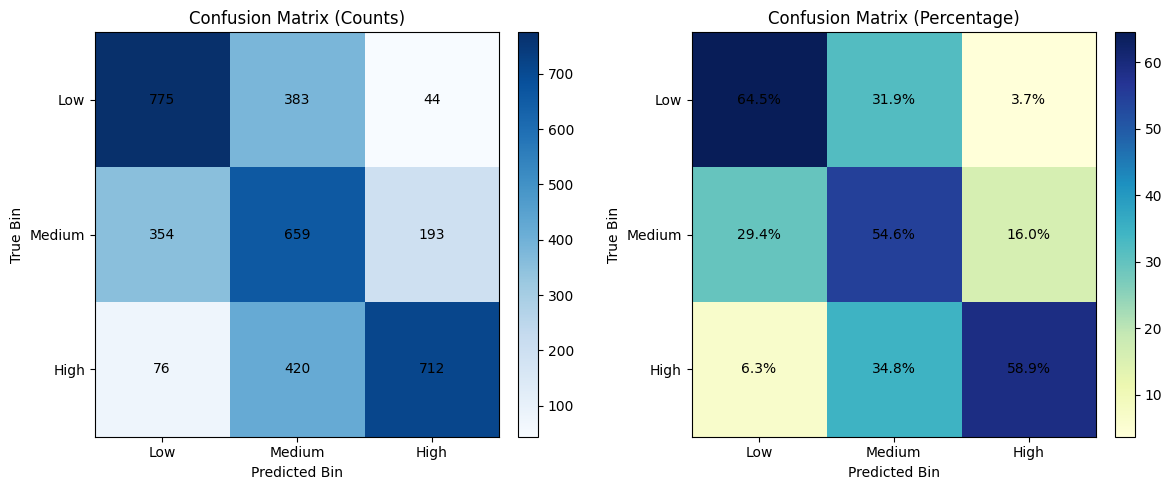


Normalized Confusion Matrix (%):
               Low       Medium      High   
Low              64.5       31.9        3.7
Medium           29.4       54.6       16.0
High              6.3       34.8       58.9


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# --- 1. Print bin range summary ---
bin_labels = ["Low", "Medium", "High"]

bin_ranges = [(bins[i], bins[i + 1]) for i in range(3)]
proportions = [np.sum(y_true_bins == i) / len(y_true_bins) * 100 for i in range(3)]

print("\nYield Bin Summary (Validation Set):")
print(f"{'Category':<10} {'Range (t/ha)':<20} {'Proportion (%)':<15}")
for lbl, (low, high), prop in zip(bin_labels, bin_ranges, proportions):
    print(f"{lbl:<10} {low:.2f} – {high:.2f} {prop:>12.1f}%")

# --- 2. Compute confusion matrices ---
cm = confusion_matrix(y_true_bins, y_pred_bins, labels=[0, 1, 2])
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True) * 100  # Normalize row-wise

# --- 3. Plot confusion matrices (counts and % side by side) ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Absolute counts
im1 = axes[0].imshow(cm, cmap='Blues')
axes[0].set_title("Confusion Matrix (Counts)")
axes[0].set_xlabel("Predicted Bin")
axes[0].set_ylabel("True Bin")
axes[0].set_xticks(np.arange(len(bin_labels)))
axes[0].set_yticks(np.arange(len(bin_labels)))
axes[0].set_xticklabels(bin_labels)
axes[0].set_yticklabels(bin_labels)

# Annotate
for i in range(len(bin_labels)):
    for j in range(len(bin_labels)):
        axes[0].text(j, i, cm[i, j], ha="center", va="center", color="black")

plt.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)

# Normalized (%)
im2 = axes[1].imshow(cm_norm, cmap='YlGnBu')
axes[1].set_title("Confusion Matrix (Percentage)")
axes[1].set_xlabel("Predicted Bin")
axes[1].set_ylabel("True Bin")
axes[1].set_xticks(np.arange(len(bin_labels)))
axes[1].set_yticks(np.arange(len(bin_labels)))
axes[1].set_xticklabels(bin_labels)
axes[1].set_yticklabels(bin_labels)

# Annotate with percentage values
for i in range(len(bin_labels)):
    for j in range(len(bin_labels)):
        axes[1].text(j, i, f"{cm_norm[i, j]:.1f}%", ha="center", va="center", color="black")

plt.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

# --- 4. Optional: Print numeric confusion matrix (percentages) ---
print("\nNormalized Confusion Matrix (%):")
print(" " * 12 + " ".join(f"{lbl:^10}" for lbl in bin_labels))
for i, lbl in enumerate(bin_labels):
    row = " ".join(f"{cm_norm[i, j]:10.1f}" for j in range(len(bin_labels)))
    print(f"{lbl:<10} {row}")

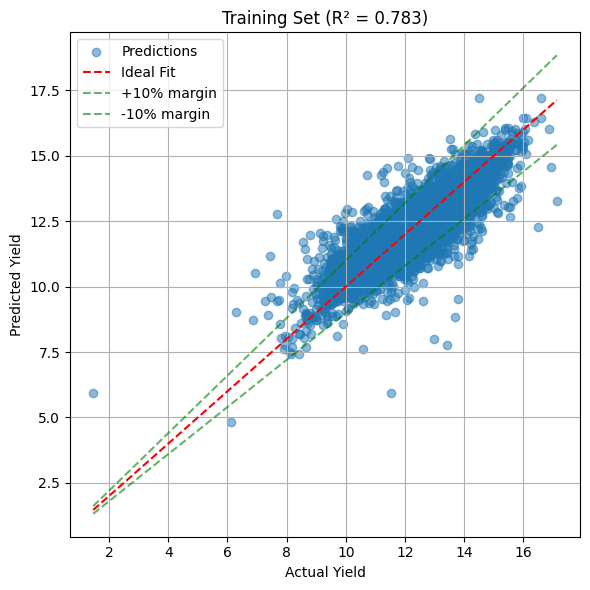

In [15]:
plot_pred_vs_actual_with_band(
    y_true_train, y_pred_train,
    f"Training Set (R² = {metrics_train['R²'][0]:.3f})"
)

In [11]:
print(X_test_scaled.shape)

(3617, 84322)


In [12]:
import shap
import numpy as np

# Choose a background sample
background = X_train_scaled[:14468] #14468

# Select some test samples for SHAP explanation
test_samples = X_test_scaled[:3617]  # 3617

/software/projects/pawsey1157/rtrivedi/setonix/pythonEnvironments/tensorflowContainer_env/machinelearning/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
explainer = shap.GradientExplainer(model, background)

shap_values = explainer.shap_values(test_samples)

In [ ]:
from tqdm import tqdm

# Assume you already have: model, background, test_samples
explainer = shap.DeepExplainer(model, background)

# Define batch size for manageable computation
batch_size = 8
n_batches = int(np.ceil(len(test_samples) / batch_size))

shap_values_list = []

for i in tqdm(range(n_batches), desc="Computing SHAP values", unit="batch"):
    batch = test_samples[i * batch_size : (i + 1) * batch_size]
    shap_vals = explainer.shap_values(batch)
    shap_values_list.append(shap_vals)

# Concatenate results
shap_values = [np.concatenate([b[i] for b in shap_values_list], axis=0)
               for i in range(len(shap_values_list[0]))]

/tmp/ipykernel_326976/1779478676.py:4: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_squeezed, test_samples, feature_names=X.columns.tolist())


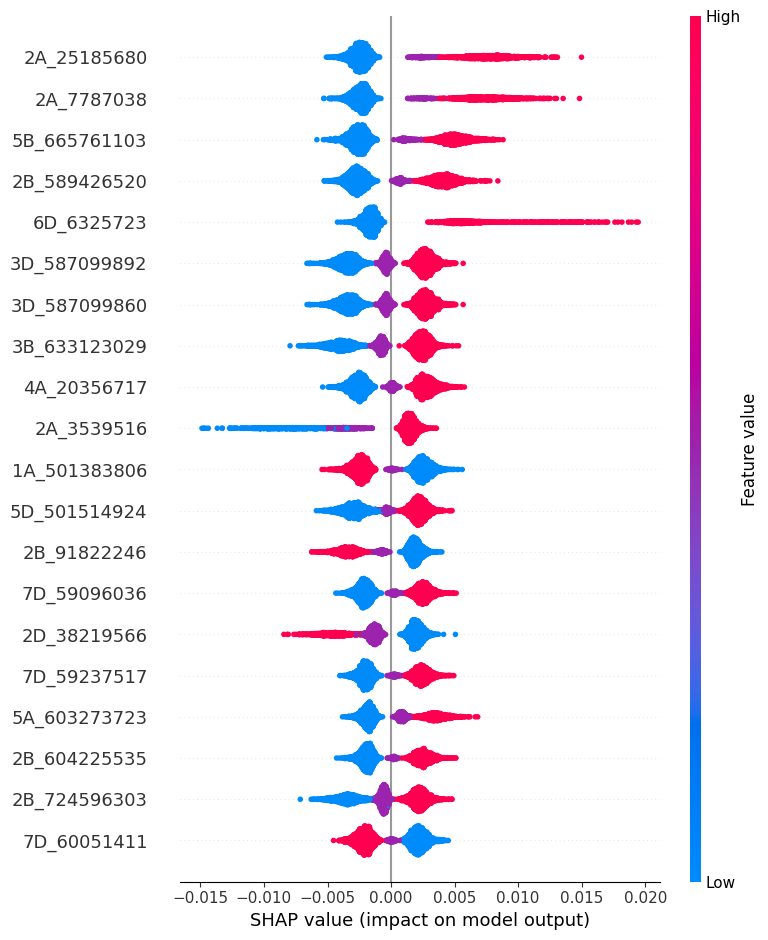

In [15]:
#All train and test samples

shap_values_squeezed = np.squeeze(shap_values)
shap.summary_plot(shap_values_squeezed, test_samples, feature_names=X.columns.tolist())

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Example: shap_values_snp is your array from SHAP for SNP-only model
# shape = (n_samples, n_snps)
# snp_names = list or array of SNP column names, e.g. ["2A_1145442", "7D_99123", ...]

mean_abs_shap = np.mean(np.abs(shap_values_geno), axis=0)

snp_df = pd.DataFrame({
    "SNP": geno_feature_cols,
    "mean_abs_shap": mean_abs_shap
})

In [13]:
# Evaluate the model
#test_loss, test_mae, test_rmse = model.evaluate(X_test_scaled, Y_test)
#print(f"Test MAE: {test_mae}")

# Make predictions
#predictions = model.predict(X_test_scaled)

# Save the model
model.save('wheat_height_predictor.h5')

/usr/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [14]:
np.corrcoef(Y_test, predictions.T)

array([[1.        , 0.66350653],
       [0.66350653, 1.        ]])

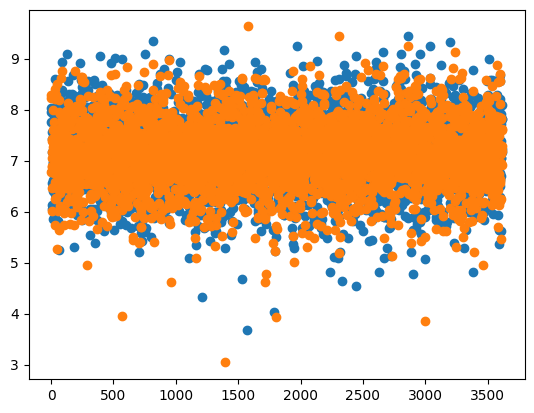

In [72]:
import matplotlib.pyplot as plt
plt.plot(Y_test, 'o')
plt.plot(predictions, 'o')
#Y_test.shape

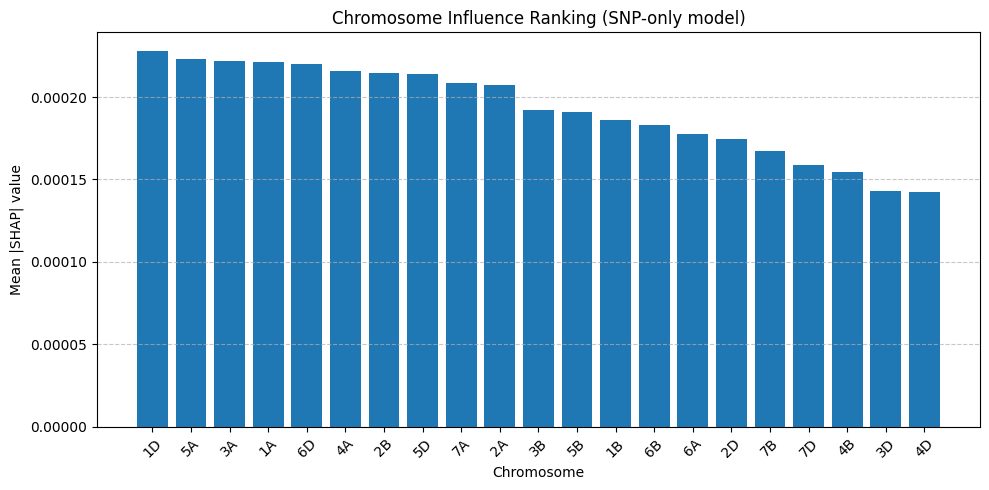

In [38]:
mean_abs_shap = np.mean(np.abs(shap_values), axis=0)
mean_abs_shap = mean_abs_shap.flatten()

snp_df = pd.DataFrame({
    "SNP": snp_names,
    "mean_abs_shap": mean_abs_shap
})

snp_df["Chromosome"] = snp_df["SNP"].str.extract(r"^([0-9A-Z]+)_")

chrom_shap = (
    snp_df.groupby("Chromosome")["mean_abs_shap"]
    .mean()
    .sort_values(ascending=False)
)

plt.figure(figsize=(10, 5))
plt.bar(chrom_shap.index, chrom_shap.values)
plt.xlabel("Chromosome")
plt.ylabel("Mean |SHAP| value")
plt.title("Chromosome Influence Ranking (SNP-only model)")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [35]:
snp_names=X_test.columns.tolist()
snp_names=np.array(snp_names)
#snp_names=snp_names.T

In [37]:
print("shap_values shape:", shap_values.shape)
print("mean_abs_shap shape:", mean_abs_shap.shape)
print("snp_names shape:", np.array(snp_names).shape)

shap_values shape: (3617, 84322, 1)
mean_abs_shap shape: (84322, 1)
snp_names shape: (84322,)
